### Get the BSDS500 dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
!wget https://raw.githubusercontent.com/leelening/rbe549/main/hw0/BSDS500.tar.xz
!tar -xvf BSDS500.tar.xz
!mv BSDS500/ /content/data/

In [ ]:
!wget https://raw.githubusercontent.com/leelening/rbe549/main/hw0/TxtFiles.tar.xz
!tar -xvf TxtFiles.tar.xz
!mv TxtFiles/ /content/data/

--2024-03-01 22:20:38--  https://raw.githubusercontent.com/leelening/rbe549/main/hw0/TxtFiles.tar.xz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55376 (54K) [application/octet-stream]
Saving to: ‘TxtFiles.tar.xz’

TxtFiles.tar.xz     100%[===================>]  54.08K  --.-KB/s    in 0.004s  

2024-03-01 22:20:38 (13.7 MB/s) - ‘TxtFiles.tar.xz’ saved [55376/55376]

TxtFiles/
TxtFiles/DirNamesTest.txt
TxtFiles/DirNamesTrain.txt
TxtFiles/LabelsTest.txt
TxtFiles/LabelsTrain.txt


In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import pandas as pd

%cd /content/drive/MyDrive/AutoPano/Phase2

/content/drive/.shortcut-targets-by-id/1CLiZb_fMfgNhTkiGrkTxoIDZascu1b9x/AutoPano/Phase2


In [ ]:

def extract_patch(image, patch_size, rho):
    M, N, _ = image.shape
    Mp, Np = patch_size

    max_x = N - Np - rho
    max_y = M - Mp - rho
    # print(max_y, N, M)

    x = np.random.randint(rho, max_x + 1)
    y = np.random.randint(rho, max_y + 1)



    top_left = (x, y)
    top_right = (x + Np, y)
    bottom_left = (x, y + Mp)
    bottom_right = (x + Np, y + Mp)

    patch = image[y:y+Mp, x:x+Np]
    # print("Displaying from extract_patch")
    # cv2_imshow(patch)
    return image, patch, top_left, top_right, bottom_left, bottom_right


def perform_perturbation(image, patch, rho, top_left, top_right, bottom_left, bottom_right):

    px_tl = np.random.uniform(-rho, rho)
    py_tl = np.random.uniform(-rho, rho)

    px_tr = np.random.uniform(-rho, rho)
    py_tr = np.random.uniform(-rho, rho)

    px_bl = np.random.uniform(-rho, rho)
    py_bl = np.random.uniform(-rho, rho)

    px_br = np.random.uniform(-rho, rho)
    py_br = np.random.uniform(-rho, rho)

    top_left_perturbed = (int(top_left[0] + px_tl), int(top_left[1] + py_tl))
    top_right_perturbed = (int(top_right[0] + px_tr), int(top_right[1] + py_tr))
    bottom_left_perturbed = (int(bottom_left[0] + px_bl), int(bottom_left[1] + py_bl))
    bottom_right_perturbed = (int(bottom_right[0] + px_br), int(bottom_right[1] + py_br))
    image_unaltered = image.copy()
    cv2.line(image, top_left_perturbed, top_right_perturbed, (0, 0, 255), 2)
    cv2.line(image, top_right_perturbed, bottom_right_perturbed, (0, 0, 255), 2)
    cv2.line(image, bottom_right_perturbed, bottom_left_perturbed, (0, 0, 255), 2)
    cv2.line(image, bottom_left_perturbed, top_left_perturbed, (0, 0, 255), 2)
    # print("Unaltered image")
    # cv2_imshow(image_unaltered)
    return image, patch, top_left_perturbed, top_right_perturbed, bottom_left_perturbed, bottom_right_perturbed,image_unaltered

def warp_image(image, original_points, perturbed_points):
    H = cv2.getPerspectiveTransform(np.float32(original_points), np.float32(perturbed_points))
    H_inv = np.linalg.inv(H)
    warped_image = cv2.warpPerspective(image, H_inv, (image.shape[1], image.shape[0]))
    transformed_points = cv2.perspectiveTransform(np.array([perturbed_points], dtype=np.float32), H_inv)[0]
    unaltered = warped_image.copy()
    for point in transformed_points:
        cv2.circle(warped_image, tuple(np.round(point).astype(int)), 5, (0, 255, 0), -1)

    min_x = int(np.min(transformed_points[:, 0]))
    max_x = int(np.max(transformed_points[:, 0]))
    min_y = int(np.min(transformed_points[:, 1]))
    max_y = int(np.max(transformed_points[:, 1]))
    warped_patch = warped_image[min_y:max_y, min_x:max_x]
    unaltered_patch = unaltered[min_y:max_y, min_x:max_x]
    # print("From warp image- unaltered patch")
    # cv2_imshow(unaltered_patch)
    return warped_image, warped_patch, unaltered_patch


def homography(perturbed_points, original_points):
    H4pt = np.zeros((4, 2))
    for i in range(4):
        delta_u = perturbed_points[i][0] - original_points[i][0]
        delta_v = perturbed_points[i][1] - original_points[i][1]

        H4pt[i][0] = delta_u
        H4pt[i][1] = delta_v

    return H4pt





In [ ]:
current_directory = os.getcwd()
image_directory = "/content/drive/MyDrive/AutoPano/Phase2/Data/Train/"
res_directory = "/content/drive/MyDrive/AutoPano/Phase2/Data"
# image = cv2.imread(os.path.join(image_directory, "75.jpg"))


stacked_patches = []
file_list = os.listdir(image_directory)
H_4 = []
image_names = []
original_points_list = []
warped_points_list = []
# Iterate over each file in the directory
for filename in file_list:
    # Check if the file is an image (you can add more image extensions if needed)
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        # Read the image using OpenCV
        image = cv2.imread(os.path.join(image_directory, filename))
        # image_names.append()
        patch_size = (100,100)
        rho = 15
        # print(image.shape)
        image_with_patch, patch, tl, tr, bl, br = extract_patch(image, patch_size, rho)
        patch1 = patch.copy()
        perturbed_image, perturbed_patch, tlp, trp, blp, brp, unaltered1 = perform_perturbation(image_with_patch, patch1, rho, tl, tr, bl, br)
        # print("Unaltered image")
        # cv2_imshow(unaltered)
        original_points = [tl, tr, bl, br]
        perturbed_points = [tlp, trp, blp, brp]

        pts2 = np.array(perturbed_points)
        pts1 = np.array(original_points)
        H_dist = (pts2-pts1).astype(np.float32)

        original_points_list.append(pts1)
        warped_points_list.append(pts2)
        #Flatten
        H_dist = np.hstack((H_dist[:,0] , H_dist[:,1]))
        H_4.append(H_dist)
        # print(H_4)
        warped_image, warped_patch, unaltered2 = warp_image(perturbed_image, original_points, perturbed_points)
        warped_image1, warped_patch1, unaltered3 = warp_image(unaltered1, original_points, perturbed_points)

        H4pt = homography(perturbed_points, original_points)
        stack = np.dstack((patch1, unaltered3))
        stacked_patches.append(stack)
        patchA = '/PatchA/' + str(filename)
        cv2.imwrite((res_directory + patchA), patch1)
        patchB = '/Patch_warped/' + str(filename)
        cv2.imwrite((res_directory+ patchB), unaltered3)
        print('Done for '+filename)
        # break
# plt.imshow(patch)
# plt.show()

# cv2_imshow(patch)
# cv2_imshow(warped_patch)
# cv2_imshow(perturbed_image)
# cv2_imshow(warped_image)
# cv2_imshow(unaltered)



# cv2_imshow(patch1)
# cv2_imshow(unaltered3)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [ ]:
current_directory = os.getcwd()
image_directory = "/content/drive/MyDrive/AutoPano/Phase2/Data/Val/"
res_directory = "/content/drive/MyDrive/AutoPano/Phase2/Data"
# image = cv2.imread(os.path.join(image_directory, "75.jpg"))


stacked_patches = []
file_list = os.listdir(image_directory)
H_4 = []
image_names = []
# Iterate over each file in the directory
for filename in file_list:
    # Check if the file is an image (you can add more image extensions if needed)
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        # Read the image using OpenCV
        image = cv2.imread(os.path.join(image_directory, filename))
        # image_names.append()
        patch_size = (100,100)
        rho = 15
        # print(image.shape)
        image_with_patch, patch, tl, tr, bl, br = extract_patch(image, patch_size, rho)
        patch1 = patch.copy()
        perturbed_image, perturbed_patch, tlp, trp, blp, brp, unaltered1 = perform_perturbation(image_with_patch, patch1, rho, tl, tr, bl, br)
        # print("Unaltered image")
        # cv2_imshow(unaltered)
        original_points = [tl, tr, bl, br]
        perturbed_points = [tlp, trp, blp, brp]

        pts2 = np.array(perturbed_points)
        pts1 = np.array(original_points)
        H_dist = (pts2-pts1).astype(np.float32)


        #Flatten
        H_dist = np.hstack((H_dist[:,0] , H_dist[:,1]))
        H_4.append(H_dist)
        # print(H_4)
        warped_image, warped_patch, unaltered2 = warp_image(perturbed_image, original_points, perturbed_points)
        warped_image1, warped_patch1, unaltered3 = warp_image(unaltered1, original_points, perturbed_points)

        H4pt = homography(perturbed_points, original_points)
        stack = np.dstack((patch1, unaltered3))
        stacked_patches.append(stack)
        patchA = '/PatchA_val/' + str(filename)
        cv2.imwrite((res_directory + patchA), patch1)
        patchB = '/Patch_warped_val/' + str(filename)
        cv2.imwrite((res_directory+ patchB), unaltered3)
        print('Done for '+filename)
        # break
# plt.imshow(patch)
# plt.show()

# cv2_imshow(patch)
# cv2_imshow(warped_patch)
# cv2_imshow(perturbed_image)
# cv2_imshow(warped_image)
# cv2_imshow(unaltered)



# cv2_imshow(patch1)
# cv2_imshow(unaltered3)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [ ]:
df = pd.DataFrame(H_4)

df.to_csv("/content/drive/MyDrive/AutoPano/Phase2/H4_val.csv", index=False)
np.save("/content/drive/MyDrive/AutoPano/Phase2/origpointsList.npy", np.array(original_points_list))
np.save("/content/drive/MyDrive/AutoPano/Phase2/warpedpointsList.npy", np.array(warped_points_list))

In [ ]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 22.3 MB/s eta 0:00:00


## Phase 2

In [ ]:
import torch
import pytorch_lightning as p1
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

Aux_M1  = torch.tensor([
          [ 0 , 0 , 0 , 0  , 0 , 0 , 0 , 0 ],
          [ 1 , 0 , 0 , 0  , 0 , 0 , 0 , 0 ],
          [ 0 , 0 , 0 , 0  , 0 , 0 , 0 , 0 ],
          [ 0 , 0 , 1 , 0  , 0 , 0 , 0 , 0 ],
          [ 0 , 0 , 0 , 0  , 0 , 0 , 0 , 0 ],
          [ 0 , 0 , 0 , 0  , 1 , 0 , 0 , 0 ],
          [ 0 , 0 , 0 , 0  , 0 , 0 , 0 , 0 ],
          [ 0 , 0 , 0 , 0  , 0 , 0 , 1 , 0 ]], dtype=torch.float32)

Aux_M2  = torch.tensor([
          [ 0 , 0 , 0 , 0  , 0 , 0 , 0 , 0 ],
          [ 0 , 1 , 0 , 0  , 0 , 0 , 0 , 0 ],
          [ 0 , 0 , 0 , 0  , 0 , 0 , 0 , 0 ],
          [ 0 , 0 , 0 , 1  , 0 , 0 , 0 , 0 ],
          [ 0 , 0 , 0 , 0  , 0 , 0 , 0 , 0 ],
          [ 0 , 0 , 0 , 0  , 0 , 1 , 0 , 0 ],
          [ 0 , 0 , 0 , 0  , 0 , 0 , 0 , 0 ],
          [ 0 , 0 , 0 , 0  , 0 , 0 , 0 , 1 ]], dtype=torch.float32)

Aux_M3  = torch.tensor([
          [0],
          [1],
          [0],
          [1],
          [0],
          [1],
          [0],
          [1]], dtype=torch.float32)



Aux_M4  = torch.tensor([
          [-1 , 0 , 0 , 0  , 0 , 0 , 0 , 0 ],
          [0 , 0 , 0 , 0  , 0 , 0 , 0 , 0 ],
          [0 , 0 ,-1 , 0  , 0 , 0 , 0 , 0 ],
          [0 , 0 , 0 , 0  , 0 , 0 , 0 , 0 ],
          [0 , 0 , 0 , 0  ,-1 , 0 , 0 , 0 ],
          [0 , 0 , 0 , 0  , 0 , 0 , 0 , 0 ],
          [0 , 0 , 0 , 0  , 0 , 0 ,-1 , 0 ],
          [0 , 0 , 0 , 0  , 0 , 0 , 0 , 0 ]], dtype=torch.float32)


Aux_M5  = torch.tensor([
          [0 ,-1 , 0 , 0  , 0 , 0 , 0 , 0 ],
          [0 , 0 , 0 , 0  , 0 , 0 , 0 , 0 ],
          [0 , 0 , 0 ,-1  , 0 , 0 , 0 , 0 ],
          [0 , 0 , 0 , 0  , 0 , 0 , 0 , 0 ],
          [0 , 0 , 0 , 0  , 0 ,-1 , 0 , 0 ],
          [0 , 0 , 0 , 0  , 0 , 0 , 0 , 0 ],
          [0 , 0 , 0 , 0  , 0 , 0 , 0 ,-1 ],
          [0 , 0 , 0 , 0  , 0 , 0 , 0 , 0 ]], dtype=torch.float32)

Aux_M6  = torch.tensor([
          [-1 ],
          [ 0 ],
          [-1 ],
          [ 0 ],
          [-1 ],
          [ 0 ],
          [-1 ],
          [ 0 ]], dtype=torch.float32)

Aux_M71 = torch.tensor([
          [0 , 1 , 0 , 0  , 0 , 0 , 0 , 0 ],
          [1 , 0 , 0 , 0  , 0 , 0 , 0 , 0 ],
          [0 , 0 , 0 , 1  , 0 , 0 , 0 , 0 ],
          [0 , 0 , 1 , 0  , 0 , 0 , 0 , 0 ],
          [0 , 0 , 0 , 0  , 0 , 1 , 0 , 0 ],
          [0 , 0 , 0 , 0  , 1 , 0 , 0 , 0 ],
          [0 , 0 , 0 , 0  , 0 , 0 , 0 , 1 ],
          [0 , 0 , 0 , 0  , 0 , 0 , 1 , 0 ]], dtype=torch.float32)

Aux_M72 = torch.tensor([
          [1 , 0 , 0 , 0  , 0 , 0 , 0 , 0 ],
          [-1 , 0 , 0 , 0  , 0 , 0 , 0 , 0 ],
          [0 , 0 , 1 , 0  , 0 , 0 , 0 , 0 ],
          [0 , 0 ,-1 , 0  , 0 , 0 , 0 , 0 ],
          [0 , 0 , 0 , 0  , 1 , 0 , 0 , 0 ],
          [0 , 0 , 0 , 0  ,-1 , 0 , 0 , 0 ],
          [0 , 0 , 0 , 0  , 0 , 0 , 1 , 0 ],
          [0 , 0 , 0 , 0  , 0 , 0 ,-1 , 0 ]], dtype=torch.float32)

Aux_M8  = torch.tensor([
          [0 , 1 , 0 , 0  , 0 , 0 , 0 , 0 ],
          [0 ,-1 , 0 , 0  , 0 , 0 , 0 , 0 ],
          [0 , 0 , 0 , 1  , 0 , 0 , 0 , 0 ],
          [0 , 0 , 0 ,-1  , 0 , 0 , 0 , 0 ],
          [0 , 0 , 0 , 0  , 0 , 1 , 0 , 0 ],
          [0 , 0 , 0 , 0  , 0 ,-1 , 0 , 0 ],
          [0 , 0 , 0 , 0  , 0 , 0 , 0 , 1 ],
          [0 , 0 , 0 , 0  , 0 , 0 , 0 ,-1 ]], dtype=torch.float32)
Aux_Mb  = torch.tensor([
          [0 ,-1 , 0 , 0  , 0 , 0 , 0 , 0 ],
          [1 , 0 , 0 , 0  , 0 , 0 , 0 , 0 ],
          [0 , 0 , 0 , -1  , 0 , 0 , 0 , 0 ],
          [0 , 0 , 1 , 0  , 0 , 0 , 0 , 0 ],
          [0 , 0 , 0 , 0  , 0 ,-1 , 0 , 0 ],
          [0 , 0 , 0 , 0  , 1 , 0 , 0 , 0 ],
          [0 , 0 , 0 , 0  , 0 , 0 , 0 ,-1 ],
          [0 , 0 , 0 , 0  , 0 , 0 , 1 , 0 ]], dtype=torch.float32)


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Running on device: {device}")


Running on device: cuda


In [ ]:
def SpatialTransformer(U, theta, out_size, name="SpatialTransformer", **kwargs):
    scale_h = True

    def _repeat(x, n_repeats):
        ones_tensor = torch.ones(n_repeats)
        expanded_tensor = ones_tensor.unsqueeze(1)
        transposed_tensor = expanded_tensor.t()
        rep = transposed_tensor.int()
        x_reshaped = x.view(-1, 1).int()
        result = torch.matmul(x_reshaped, rep)
        return result.view(-1).to(device)

    def _interpolate(im, x, y, out_size, scale_h):
        num_batch = im.size(0)
        height = im.size(1)
        width = im.size(2)
        channels = 1 #im.size(3)
        x = x.float()
        y = y.float()
        height_f = float(height)
        width_f = float(width)
        out_height = out_size[0]
        out_width = out_size[1]
        zero = torch.tensor(0, dtype=torch.int32)
        max_y = height - 1
        max_x = width - 1

        if scale_h:
            # print("--Inter- scale_h:", scale_h)
            x = (x + 1.0) * width_f / 2.0
            y = (y + 1.0) * height_f / 2.0
        x = x.view(-1)
        y = y.view(-1)
        x0 = torch.floor(x).to(torch.int32)
        x1 = x0 + 1
        y0 = torch.floor(y).to(torch.int32)
        y1 = y0 + 1

        x0 = torch.clamp(x0, zero, max_x)
        x1 = torch.clamp(x1, zero, max_x)
        y0 = torch.clamp(y0, zero, max_y)
        y1 = torch.clamp(y1, zero, max_y)
        dim2 = width
        dim1 = width * height
        base = _repeat(torch.arange(num_batch) * dim1, out_height * out_width)
        # print(y0.shape, base.shape)
        # y0 = y0.view(-1)
        # y1 = y1.view(-1)
        # x0 = x0.view(-1)
        # x1 = x1.view(-1)
        base_y0 = base + y0 * dim2
        base_y1 = base + y1 * dim2
        idx_a = base_y0 + x0
        idx_b = base_y1 + x0
        idx_c = base_y0 + x1
        idx_d = base_y1 + x1

        im_flat = im.reshape(-1, channels).float()
        Ia = im_flat.index_select(0, idx_a)
        Ib = im_flat.index_select(0, idx_b)
        Ic = im_flat.index_select(0, idx_c)
        Id = im_flat.index_select(0, idx_d)

        x0_f = x0.float()
        x1_f = x1.float()
        y0_f = y0.float()
        y1_f = y1.float()
        wa = ((x1_f - x) * (y1_f - y)).unsqueeze(1)
        wb = ((x1_f - x) * (y - y0_f)).unsqueeze(1)
        wc = ((x - x0_f) * (y1_f - y)).unsqueeze(1)
        wd = ((x - x0_f) * (y - y0_f)).unsqueeze(1)
        output = torch.add(wa * Ia, wb * Ib)
        output = torch.add(output, wc * Ic)
        output = torch.add(output, wd * Id)

        return output.to(device)


    def _meshgrid(height, width, scale_h):
        if scale_h:
            x_t = torch.matmul(torch.ones(height, 1), torch.linspace(-1.0, 1.0, width).unsqueeze(1).transpose(1, 0))
            y_t = torch.matmul(torch.linspace(-1.0, 1.0, height).unsqueeze(1), torch.ones(1, width))
        else:
            x_t = torch.matmul(torch.ones(height, 1), torch.linspace(0.0, float(width), width).unsqueeze(1).transpose(1, 0))
            y_t = torch.matmul(torch.linspace(0.0, float(height), height).unsqueeze(1), torch.ones(1, width))

        x_t_flat = x_t.view(1, -1)
        y_t_flat = y_t.view(1, -1)

        ones = torch.ones_like(x_t_flat)
        grid = torch.cat((x_t_flat, y_t_flat, ones), 0)

        return grid.to(device)

    def _transform(theta, input_dim, out_size, scale_h):
        num_batch = input_dim.size(0)
        height = input_dim.size(1)
        width = input_dim.size(2)
        num_channels = 1#input_dim.size(3)

        theta = theta.view(-1, 3, 3)
        theta = theta.float()

        height_f = float(height)
        width_f = float(width)
        out_height = out_size[0]
        out_width = out_size[1]
        grid = _meshgrid(out_height, out_width, scale_h).to(device)
        grid = grid.unsqueeze(0)
        grid = grid.view(-1)
        grid = grid.repeat(num_batch)
        grid = grid.view(num_batch, 3, -1)

        T_g = torch.matmul(theta, grid)
        x_s = T_g[:, 0:1, :]
        y_s = T_g[:, 1:2, :]
        t_s = T_g[:, 2:3, :]
        t_s_flat = t_s.view(num_batch, -1)

        zero = torch.tensor(0, dtype=torch.float32)
        one = torch.tensor(1, dtype=torch.float32)

        small = torch.tensor(1e-7, dtype=torch.float32)
        smallers = 1e-6 * (one - (torch.abs(t_s_flat) >= small).float())

        t_s_flat = t_s_flat + smallers
        condition = torch.sum((torch.abs(t_s_flat) > small).float())

        x_s_flat = x_s.view(num_batch, -1) / t_s_flat
        y_s_flat = y_s.view(num_batch, -1) / t_s_flat

        # Interpolate
        input_transformed = _interpolate(input_dim, x_s_flat, y_s_flat, out_size, scale_h)

        output = input_transformed.view(num_batch, out_height, out_width, num_channels)
        return output, condition

    output, condition = _transform(theta, U, out_size, scale_h)
    return output, condition

def batch_transformer(U, thetas, out_size):
    num_batch, num_transforms = thetas.size()[:2]
    indices = [[i] * num_transforms for i in range(num_batch)]
    indices = torch.tensor(indices).reshape(-1)
    input_repeated = U.index_select(0, indices)
    return SpatialTransformer(input_repeated, thetas, out_size)

### Neural Network Construction

In [ ]:

def accuracy(outputs, labels):
    # _, preds = torch.max(outputs, dim=1)
    # return torch.tensor(torch.sum(preds == labels).item() / len(preds))
    return torch.mean(torch.abs(outputs - labels))


def loss_fn(out, labels):
    ###############################################
    # Fill your loss function of choice here!
    ###############################################
    loss_func = nn.MSELoss()
    labels = labels.float()
    loss = torch.norm(loss_func(out,labels))
    return loss

def loss_fn_unsup(out, labels):
    ###############################################
    # Fill your loss function of choice here!
    ###############################################
    # print('Out' + str(out.shape))
    # print('labels' + str(labels.shape))
    loss_func = nn.L1Loss()
    labels = labels.float().to(device)
    loss = loss_func(out,labels)
    return loss

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = loss_fn(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = loss_fn(out, labels)   # Calculate loss
        mae = accuracy(out, labels)           # Calculate accuracy
        return {'loss': loss.detach(), 'mae': mae}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['mae'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'loss': epoch_loss.item(), 'mae': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], loss: {:.4f}, mae: {:.4f}".format(epoch, result['loss'], result['mae']))

class Unsup_Homography(p1.LightningModule):
  def __init__(self, batchsize): #, InputSize, OutputSize):
      """
      Inputs:
      InputSize - Size of the Input
      OutputSize - Size of the Output
      """
      #############################
      # Fill your network initialization of choice here!
      #############################


      super().__init__()
      #################3

      # self.corners = corners
      self.batchsize = batchsize

      self.layer1Conv = nn.Conv2d(in_channels=2, out_channels=64, kernel_size=3, padding=1, stride=1)
      self.layer1batch = nn.BatchNorm2d(64)
      self.layer1relu = nn.ReLU()

      #################
      self.layer2Conv = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1)
      self.layer2batch = nn.BatchNorm2d(64)
      self.layer2relu = nn.ReLU()

      # self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

      ###############3
      self.layer3Conv = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)
      self.layer3batch = nn.BatchNorm2d(128)
      self.layer3relu = nn.ReLU()

     #################3
      self.layer4Conv = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1)
      self.layer4batch = nn.BatchNorm2d(128)
      self.layer4relu = nn.ReLU()

      self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
      self.dropout = nn.Dropout(0.5)
      #FC 1024, FC 8x21, softmax
      self.fc1 = nn.Linear(18432, 1024)
      self.fc2 = nn.Linear(1024, 8)

  def TensorDLT(self, H4, corners_a, batch_size):
      corners_a_tile = corners_a.unsqueeze(2)  # batch_size x 8 x 1

      # Solve for H using DLT
      pred_h4p_tile = H4.unsqueeze(2)  # batch_size x 8 x 1

      # 4 points on the second image
      pred_corners_b_tile = pred_h4p_tile.to(device) + corners_a_tile.to(device)

      # Obtain 8 auxiliary tensors
      M1_tile = torch.tile(Aux_M1.unsqueeze(0), [batch_size, 1, 1]).to(device)
      M2_tile = torch.tile(Aux_M2.unsqueeze(0), [batch_size, 1, 1]).to(device)
      M3_tile = torch.tile(Aux_M3.unsqueeze(0), [batch_size, 1, 1]).to(device)
      M4_tile = torch.tile(Aux_M4.unsqueeze(0), [batch_size, 1, 1]).to(device)
      M5_tile = torch.tile(Aux_M5.unsqueeze(0), [batch_size, 1, 1]).to(device)
      M6_tile = torch.tile(Aux_M6.unsqueeze(0), [batch_size, 1, 1]).to(device)
      M71_tile = torch.tile(Aux_M71.unsqueeze(0), [batch_size, 1, 1]).to(device)
      M72_tile = torch.tile(Aux_M72.unsqueeze(0), [batch_size, 1, 1]).to(device)
      M8_tile = torch.tile(Aux_M8.unsqueeze(0), [batch_size, 1, 1]).to(device)
      Mb_tile = torch.tile(Aux_Mb.unsqueeze(0), [batch_size, 1, 1]).to(device)

      # Form the equations Ax = b to compute H
      A1 = torch.matmul(M1_tile, corners_a_tile)  # Column 1
      A2 = torch.matmul(M2_tile, corners_a_tile)  # Column 2
      A3 = M3_tile  # Column 3
      A4 = torch.matmul(M4_tile, corners_a_tile)  # Column 4
      A5 = torch.matmul(M5_tile, corners_a_tile)  # Column 5
      A6 = M6_tile  # Column 6
      A7 = torch.matmul(M71_tile, pred_corners_b_tile) * torch.matmul(M72_tile, corners_a_tile)  # Column 7
      A8 = torch.matmul(M71_tile, pred_corners_b_tile) * torch.matmul(M8_tile, corners_a_tile)   # Column 8

      # Reshape A1-A8 as 8x1 and stack them column-wise
      A = torch.stack([A1.view(-1, 8), A2.view(-1, 8), A3.view(-1, 8), A4.view(-1, 8),
                      A5.view(-1, 8), A6.view(-1, 8), A7.view(-1, 8), A8.view(-1, 8)], axis=1)
      A = A.transpose(1, 2)

      # Build b matrix
      b = torch.matmul(Mb_tile, pred_corners_b_tile)

      # Solve the Ax = b to get h11 - h32 as H8 matrix
      H_8 = torch.linalg.solve(A,b)  # batch_size x 8 -  has values from H11-H32

      # Add h33 = ones to the last columns to complete H matrix
      h_33 = torch.ones(batch_size, 1, 1).to(device)
      H_9 = torch.cat([H_8, h_33], 1)
      H_flat = H_9.view(-1, 9)
      H = H_flat.view(-1, 3, 3)  # batch_size x 3 x 3

      return H.to(device)

  def initiate_corners(self, corners_list) :
    self.corners = corners_list


  def generate_patch_indices(self, corners_a):
    patch_indices = []

    # print("Corners: " + str(corners_a.shape))
    for i in range(corners_a.shape[0]):
        xmin, ymin = int(corners_a[i, 0].item()), int(corners_a[i, 1].item())
        xmax, ymax = int(corners_a[i, 6].item()), int(corners_a[i, 7].item())
        # integer_constant = int(tensor_value.item())
        # print(xmin)
        # Create meshgrid
        X, Y = np.mgrid[xmin:xmax, ymin:ymax]
        # print("X Shape ", str(X.shape), " Y Shape: ", str(Y.shape))

        # Stack X and Y coordinates
        patch_indices.append(torch.mean(torch.tensor(np.dstack((Y, X)), dtype=torch.float64),-1, keepdim=True, dtype=torch.float64))
        # print("Patch indices from func: ", str(np.array(patch_indices).shape))
    return torch.stack(patch_indices).to(device)

  def forward(self, xb):
      """
      Input:
      xb is a MiniBatch of the current image
      Outputs:
      out - output of the network
      """
      #############################
      # Fill your network structure of choice here!
      #############################
      #unsure about the values!
      # print("In forward" + str(xb.shape))
      x = self.layer1relu(self.layer1batch(self.layer1Conv(xb)))
      x = self.layer2relu(self.layer2batch(self.layer2Conv(x)))
      x = self.maxpool(x)
      x = self.layer2relu(self.layer2batch(self.layer2Conv(x)))
      x = self.layer2relu(self.layer2batch(self.layer2Conv(x)))
      x = self.maxpool(x)
      x = self.layer3relu(self.layer3batch(self.layer3Conv(x)))
      x = self.layer4relu(self.layer4batch(self.layer4Conv(x)))
      x = self.maxpool(x)
      x = self.layer4relu(self.layer4batch(self.layer4Conv(x)))
      x = self.layer4relu(self.layer4batch(self.layer4Conv(x)))
      x = self.dropout(x)
      x = x.view(x.size(0), -1)
      # print(x.shape)
      x = self.fc1(x)
      x = self.fc2(x)
      # x = self.layer3(x)
      out = x
      # print("After forward" + str(out.shape))
      batch_size, h,w = list(xb[:,0,:,:].shape)
      channels = 1
      self.corners = torch.as_tensor(self.corners, dtype=torch.float32)
      self.corners = torch.reshape(self.corners, (self.batchsize, 8))

      h_batch = self.TensorDLT(out, self.corners, self.batchsize)
      # print("H_Batch" + str(h_batch.shape))
      tensor_M = torch.tensor([[w/2.0, 0., w/2.0],
                  [0., h/2.0, h/2.0],
                  [0., 0., 1.]],dtype = torch.float32).to(device)


      tensor_M = torch.unsqueeze(tensor_M, dim=0)
      M_batches = tensor_M.repeat(batch_size, 1, 1)

      M_inv = torch.linalg.inv(tensor_M)
      tensor_M_inv = torch.as_tensor(M_inv, dtype=torch.float32)
      M_inv_batches = tensor_M_inv.repeat(batch_size, 1, 1)
      H_scaled = torch.matmul(torch.matmul(M_inv_batches, h_batch), M_batches).to(device)

      warped_Ia, _ = SpatialTransformer(xb[:,0,:,:],H_scaled,(h,w) )
      # Reshape warped_Ia to [batch_size, h * w]
      # print("Warped IA" + str(warped_Ia.shape))
      warped_Ia_reshaped = warped_Ia.view(batch_size, -1)

      patch_indices = self.generate_patch_indices(self.corners)
      # Gather patches from warped_Ia using patch_indices
      # print(patch_indices.shape, warped_Ia_reshaped.shape)
      patch_indices = patch_indices.view(batch_size, -1)
      # print("PATCH INDICES"+ str(patch_indices.shape))
      warped_Pa = torch.gather(warped_Ia_reshaped, 1, patch_indices.to(torch.int64))

      # Transpose the gathered patches
      warped_Pa = warped_Pa.transpose(-2, -1)

      # Reshape warped_Pa
      warped_Pa = warped_Pa.reshape(batch_size, 100, 100, 1)

      return out, warped_Pa, h_batch


  def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = loss_fn(out, labels) # Calculate loss
        return loss

  def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = loss_fn(out, labels)   # Calculate loss
        mae = accuracy(out, labels)           # Calculate accuracy
        return {'loss': loss.detach(), 'mae': mae}

  def validation_epoch_end(self, outputs):
        batch_losses = [x['loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['mae'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'loss': epoch_loss.item(), 'mae': epoch_acc.item()}

  def epoch_end(self, epoch, result):
        print("Epoch [{}], loss: {:.4f}, mae: {:.4f}".format(epoch, result['loss'], result['mae']))





In [ ]:
import time
import glob
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

def tic():
    """
    Function to start timer
    Tries to mimic tic() toc() in MATLAB
    """
    StartTime = time.time()
    return StartTime

def toc(StartTime):
    """
    Function to stop timer
    Tries to mimic tic() toc() in MATLAB
    """
    return time.time() - StartTime

def FindLatestModel(CheckPointPath):
    """
    Finds Latest Model in CheckPointPath
    Inputs:
    CheckPointPath - Path where you have stored checkpoints
    Outputs:
    LatestFile - File Name of the latest checkpoint
    """
    FileList = glob.glob(CheckPointPath + '*.ckpt.index') # * means all if need specific format then *.csv
    LatestFile = max(FileList, key=os.path.getctime)
    # Strip everything else except needed information
    LatestFile = LatestFile.replace(CheckPointPath, '')
    LatestFile = LatestFile.replace('.ckpt.index', '')
    return LatestFile


def convertToOneHot(vector, NumClasses):
    """
    Inputs:
    vector - vector of argmax indexes
    NumClasses - Number of classes
    """
    return np.equal.outer(vector, np.arange(NumClasses)).astype(np.float)

### Train your neural network

In [ ]:
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torch.optim import AdamW
# from torchvision.datasets import CIFAR10
import cv2
import sys
import os
import numpy as np
import random
import skimage
import PIL
import os
import glob
import random
from skimage import data, exposure, img_as_float
import matplotlib.pyplot as plt
import numpy as np
import time
from torchvision.transforms import ToTensor
import argparse
import shutil
import string
from termcolor import colored, cprint
import math as m
from tqdm.notebook import tqdm
from torch.optim import Adam

def SetupAll(CheckPointPath):
    """
    Inputs:
    CheckPointPath - Path to save checkpoints/model
    Outputs:
    SaveCheckPoint - Save checkpoint every SaveCheckPoint iteration in every epoch, checkpoint saved automatically after every epoch
    ImageSize - Size of the image
    NumTrainSamples - length(Train)
    TrainLabels - Labels corresponding to Train
    NumClasses - Number of classes
    """
    # Read and Setup Labels
    LabelsPathTrain = '/content/drive/MyDrive/AutoPano/Phase2/H4.csv'
    TrainSet = ReadDirNames('/content/drive/MyDrive/AutoPano/Phase2/train_images.txt')
    TrainLabels = ReadLabels(LabelsPathTrain)

    # If CheckPointPath doesn't exist make the path
    if(not (os.path.isdir(CheckPointPath))):
       os.makedirs(CheckPointPath)

    # Save checkpoint every SaveCheckPoint iteration in every epoch, checkpoint saved automatically after every epoch
    SaveCheckPoint = 100

    # Image Input Shape
    ImageSize = [100,100, 3]
    NumTrainSamples = len(TrainSet)

    # # Number of classes
    # NumClasses = 10

    return TrainSet, SaveCheckPoint, ImageSize, NumTrainSamples, TrainLabels#, NumClasses


def ReadLabels(LabelsPathTrain):
    if(not (os.path.isfile(LabelsPathTrain))):
        print('ERROR: Train Labels do not exist in '+LabelsPathTrain)
        sys.exit()
    else:
       data = pd.read_csv(LabelsPathTrain, index_col = False)
       data = data.to_numpy()
    return data



def ReadDirNames(ReadPath):
    """
    Inputs:
    ReadPath is the path of the file you want to read
    Outputs:
    DirNames is the data loaded from /content/data/TxtFiles/DirNames.txt which has full path to all image files without extension
    """
    # Read text files
    DirNames = open(ReadPath, 'r')
    DirNames = DirNames.read()
    DirNames = DirNames.split()
    return DirNames


def GenerateBatch(TrainSet, TrainLabels, ImageSize, MiniBatchSize,corners, flag):
    """
    Inputs:
    TrainSet - Variable with Subfolder paths to train files
    NOTE that Train can be replaced by Val/Test for generating batch corresponding to validation (held-out testing in this case)/testing
    TrainLabels - Labels corresponding to Train
    NOTE that TrainLabels can be replaced by Val/TestLabels for generating batch corresponding to validation (held-out testing in this case)/testing
    ImageSize is the Size of the Image
    MiniBatchSize is the size of the MiniBatch

    Outputs:
    I1Batch - Batch of images
    LabelBatch - Batch of one-hot encoded labels
    """
    I1Batch = []
    LabelBatch = []
    corners = corners.reshape((5000,8))
    corners_list = []
    labels_unsup = []
    ImageNum = 0
    while ImageNum < MiniBatchSize:
        # Generate random image
        Rand = random.choice(TrainSet)

        ImageNum += 1

        if flag == 1 :
          patchesA = "/content/drive/MyDrive/AutoPano/Phase2/Data/PatchA/" + Rand
          patchesB = "/content/drive/MyDrive/AutoPano/Phase2/Data/Patch_warped/" + Rand
        else :
          patchesA = "/content/drive/MyDrive/AutoPano/Phase2/Data/PatchA_val/" + Rand
          patchesB = "/content/drive/MyDrive/AutoPano/Phase2/Data/Patch_warped_val/" + Rand

        img1 = cv2.cvtColor(cv2.imread(patchesA), cv2.COLOR_BGR2GRAY)
        img2 = cv2.cvtColor(cv2.imread(patchesB), cv2.COLOR_BGR2GRAY)
        temp_img2 = torch.from_numpy(img2)
        stack = np.float32(np.dstack((img1,img2)))
        # print(stack.shape)
        #stack = np.float32(np.concatenate([img1,img2],axis=2))
        stack = np.transpose(stack, (2, 0, 1))
        rand = TrainSet.index(Rand)
        h4pt = TrainLabels[rand]
        I1Batch.append(torch.from_numpy(stack))
        LabelBatch.append(torch.tensor(h4pt))
        corners_list.append(torch.from_numpy(corners[rand]))
        labels_unsup.append(temp_img2)
        ##########################################################
    	  # Add any standardization or data augmentation here!
    	  ##########################################################

        # I1, Label = TrainSet[RandIdx]

        # # Append All Images and Mask
        # I1Batch.append(I1)
        # LabelBatch.append(torch.tensor(Label))

    return torch.stack(I1Batch).to(device), torch.stack(LabelBatch).to(device), torch.stack(labels_unsup).to(device).unsqueeze(-1), torch.stack(corners_list).to(device)


def PrettyPrint(NumEpochs, DivTrain, MiniBatchSize, NumTrainSamples, LatestFile):
    """
    Prints all stats with all arguments
    """
    print('Number of Epochs Training will run for ' + str(NumEpochs))
    print('Factor of reduction in training data is ' + str(DivTrain))
    print('Mini Batch Size ' + str(MiniBatchSize))
    print('Number of Training Images ' + str(NumTrainSamples))
    if LatestFile is not None:
        print('Loading latest checkpoint with the name ' + LatestFile)

def TrainOperation(TrainLabels, NumTrainSamples, ImageSize,
                   NumEpochs, MiniBatchSize, SaveCheckPoint, CheckPointPath,
                   DivTrain, LatestFile, TrainSet, LogsPath):
    """
    Inputs:
    TrainLabels - Labels corresponding to Train/Test
    NumTrainSamples - length(Train)
    ImageSize - Size of the image
    NumEpochs - Number of passes through the Train data
    MiniBatchSize is the size of the MiniBatch
    SaveCheckPoint - Save checkpoint every SaveCheckPoint iteration in every epoch, checkpoint saved automatically after every epoch
    CheckPointPath - Path to save checkpoints/model
    DivTrain - Divide the data by this number for Epoch calculation, use if you have a lot of dataor for debugging code
    LatestFile - Latest checkpointfile to continue training
    TrainSet - The training dataset
    LogsPath - Path to save Tensorboard Logs
    Outputs:
    Saves Trained network in CheckPointPath and Logs to LogsPath
    """
    # Initialize the model
    # model = HomographyModel(InputSize=3*32*32,OutputSize=10)

    # model = HomographyModel().to(device)

    corners = np.load('/content/drive/MyDrive/AutoPano/Phase2/origpointsList.npy')
    model = Unsup_Homography(MiniBatchSize).to(device)
    ###############################################
    # Fill your optimizer of choice here!
    ###############################################
    Optimizer = Adam(model.parameters(),lr = 1e-5)

    # Tensorboard
    # Create a summary to monitor loss tensor
    Writer = SummaryWriter(LogsPath)

    if LatestFile is not None:
        CheckPoint = torch.load(CheckPointPath + LatestFile + '.ckpt')
        # Extract only numbers from the name
        StartEpoch = int(''.join(c for c in LatestFile.split('a')[0] if c.isdigit()))
        model.load_state_dict(CheckPoint['model_state_dict'])
        print('Loaded latest checkpoint with the name ' + LatestFile + '....')
    else:
        StartEpoch = 0
        print('New model initialized....')

    # ADD VALIDATION SET IMAGES
    validation_set = ReadDirNames("/content/drive/MyDrive/AutoPano/Phase2/val_image_names.txt")
    validation_labels = ReadLabels("/content/drive/MyDrive/AutoPano/Phase2/H4_val.csv")
    loss_list = []
    for Epochs in tqdm(range(StartEpoch, NumEpochs)):
        loss1 = 0
        NumIterationsPerEpoch = int(NumTrainSamples/MiniBatchSize/DivTrain)
        for PerEpochCounter in tqdm(range(NumIterationsPerEpoch)):
            Batch = GenerateBatch(TrainSet, TrainLabels, ImageSize, MiniBatchSize, corners, 1)
            # print(Batch[0].shape)
            # Predict output with forward pass
            corners_list = Batch[3]
            model.initiate_corners(corners_list)
            model.train()
            patchesB = Batch[2]

            _,PredicatedCoordinatesBatch,_ = model(Batch[0])
            # print(PredicatedCoordinatesBatch.shape)
            LossThisBatch = loss_fn_unsup(PredicatedCoordinatesBatch, patchesB)

            Optimizer.zero_grad()
            LossThisBatch.backward()
            Optimizer.step()
            loss1+= LossThisBatch
            # Save checkpoint every some SaveCheckPoint's iterations
            if PerEpochCounter % SaveCheckPoint == 0:

                Writer.add_scalar(
                    "LossEveryIter",
                    LossThisBatch,
                    Epochs * NumIterationsPerEpoch + PerEpochCounter,
                )
                # If you don't flush the tensorboard doesn't update until a lot of iterations!
                Writer.flush()

                # # Save the Model learnt in this epoch
                SaveName =  CheckPointPath + str(Epochs) + 'a' + str(PerEpochCounter) + 'model.ckpt'

                # torch.save({'epoch': Epochs,'model_state_dict': model.state_dict(),'optimizer_state_dict': Optimizer.state_dict(),'loss': LossThisBatch}, SaveName)
                # print('\n' + SaveName + ' Model Saved...')
                # print('\n Loss for '+"Epoch "+ str(Epochs) + " Counter " + str(PerEpochCounter) + ": " + str(LossThisBatch))
                print(LossThisBatch.item())

        loss1 = loss1/(5000/MiniBatchSize)
        print(loss1)
        loss_list.append(loss1.item())

        # model.eval()
        # Save model every epoch
        SaveName = CheckPointPath + str(Epochs) + 'model.ckpt'
        torch.save({'epoch': Epochs,'model_state_dict': model.state_dict(),'optimizer_state_dict': Optimizer.state_dict(),'loss': loss1}, SaveName)
        print('\n' + SaveName + ' Model Saved...')
        # print("Epoch " + str(Epochs) + "Train_Loss: " + str(loss1))

        # # Validation
        # with torch.no_grad():
        # result = model.validation_step(GenerateBatch(validation_set, validation_labels, ImageSize, 100, 0))
        #   print("Epoch " + str(Epochs) + "Val_Loss: " + str(result["loss"]))
        #   model.epoch_end(Epochs, result)

        #  # Tensorboard
        # Writer.add_scalar('LossEveryEpoch_val', result["loss"], Epochs*NumIterationsPerEpoch + PerEpochCounter)
        # Writer.add_scalar('Error', result["mae"], Epochs*NumIterationsPerEpoch + PerEpochCounter)
        # # If you don't flush the tensorboard doesn't update until a lot of iterations!
        # Writer.flush()

    np.savetxt('/content/drive/MyDrive/AutoPano/Phase2/unsup_50_64.txt', loss_list)







# Default Hyperparameters
NumEpochs = 50
# TrainSet = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        # download=True, transform=ToTensor())
DivTrain = 1.0
MiniBatchSize = 64
LoadCheckPoint = 0
CheckPointPath = "/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/"
LogsPath = "/content/drive/MyDrive/AutoPano/Phase2/Logs_unsup"

# Setup all needed parameters including file reading
TrainSet, SaveCheckPoint, ImageSize, NumTrainSamples, TrainLabels = SetupAll(CheckPointPath)

# Find Latest Checkpoint File
if LoadCheckPoint==1:
    LatestFile = FindLatestModel(CheckPointPath)
else:
    LatestFile = None

# Pretty print stats
PrettyPrint(NumEpochs, DivTrain, MiniBatchSize, NumTrainSamples, LatestFile)

TrainOperation(TrainLabels, NumTrainSamples, ImageSize,
                NumEpochs, MiniBatchSize, SaveCheckPoint, CheckPointPath,
                DivTrain, LatestFile, TrainSet, LogsPath)

Number of Epochs Training will run for 50
Factor of reduction in training data is 1.0
Mini Batch Size 64
Number of Training Images 5000
New model initialized....


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

82.02593994140625
tensor(112.4535, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/0model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

114.01042175292969
tensor(113.4823, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/1model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

103.9893569946289
tensor(112.6525, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/2model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

112.29901885986328
tensor(113.5019, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/3model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

110.5666732788086
tensor(112.5064, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/4model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

105.50364685058594
tensor(113.8359, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/5model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

113.53813171386719
tensor(112.7753, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/6model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

109.9086685180664
tensor(112.7131, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/7model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

110.1209716796875
tensor(113.9045, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/8model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

99.58931732177734
tensor(113.2204, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/9model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

118.0846939086914
tensor(113.5703, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/10model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

125.9502182006836
tensor(107.6364, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/11model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

102.57515716552734
tensor(104.7109, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/12model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

109.98907470703125
tensor(105.8607, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/13model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

104.26173400878906
tensor(105.0949, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/14model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

106.82740020751953
tensor(104.6938, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/15model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

109.50389862060547
tensor(104.3130, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/16model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

97.77037048339844
tensor(98.5176, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/17model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

103.45481872558594
tensor(95.4883, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/18model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

99.9909439086914
tensor(100.0255, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/19model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

99.56558227539062
tensor(97.7073, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/20model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

96.10563659667969
tensor(97.1843, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/21model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

102.62181854248047
tensor(98.3281, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/22model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

97.70691680908203
tensor(96.8348, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/23model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

94.62582397460938
tensor(99.4348, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/24model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

104.67667388916016
tensor(105.2242, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/25model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

105.97372436523438
tensor(99.6207, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/26model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

93.31798553466797
tensor(97.8754, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/27model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

98.0890121459961
tensor(97.7965, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/28model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

100.4004135131836
tensor(98.9358, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/29model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

88.15997314453125
tensor(99.7206, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/30model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

107.3365478515625
tensor(105.7583, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/31model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

102.0257797241211
tensor(100.1669, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/32model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

95.50321197509766
tensor(99.8366, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/33model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

101.65422058105469
tensor(100.0259, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/34model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

100.56021118164062
tensor(98.9211, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/35model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

106.1502685546875
tensor(98.4161, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/36model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

105.59269714355469
tensor(98.9400, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/37model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

103.53739929199219
tensor(97.8382, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/38model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

94.88639068603516
tensor(99.6572, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/39model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

96.16134643554688
tensor(100.8587, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/40model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

95.78303527832031
tensor(98.9227, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/41model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

92.13263702392578
tensor(98.1816, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/42model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

99.43284606933594
tensor(98.1872, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/43model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

96.41316223144531
tensor(99.9373, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/44model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

92.34598541259766
tensor(99.8885, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/45model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

94.062744140625
tensor(100.1107, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/46model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

94.69274139404297
tensor(100.0059, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/47model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

94.64620208740234
tensor(98.3813, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/48model.ckpt Model Saved...


  0%|          | 0/78 [00:00<?, ?it/s]

99.45172119140625
tensor(99.7007, device='cuda:0', grad_fn=<DivBackward0>)

/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/49model.ckpt Model Saved...


### Test your neural network

In [ ]:
import cv2
import os
import sys
import glob
import random
from skimage import data, exposure, img_as_float
import matplotlib.pyplot as plt
import numpy as np
import time
from torchvision.transforms import ToTensor
import argparse
import shutil
import string
import math as m
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
import torch

def SetupAll():
    """
    Outputs:
    ImageSize - Size of the Image
    """
    # Image Input Shape
    ImageSize = [1,2, 100, 100]

    return ImageSize

def StandardizeInputs(Img):
    ##########################################################################
    # Add any standardization or cropping/resizing if used in Training here!
    ##########################################################################
    return Img

def ReadImages(Img):
    """
    Outputs:
    I1Combined - I1 image after any standardization and/or cropping/resizing to ImageSize
    I1 - Original I1 image for visualization purposes only
    """
    I1 = Img

    if(I1 is None):
        # OpenCV returns empty list if image is not read!
        print('ERROR: Image I1 cannot be read')
        sys.exit()

    I1S = StandardizeInputs(np.float32(I1))

    I1Combined = np.expand_dims(I1S, axis=0)

    return I1Combined, I1


def TestOperation(ImageSize, ModelPath, TestSet, LabelsPathPred):
    """
    Inputs:
    ImageSize is the size of the image
    ModelPath - Path to load trained model from
    TestSet - The test dataset
    LabelsPathPred - Path to save predictions
    Outputs:
    Predictions written to /content/data/TxtFiles/PredOut.txt
    """
    # Predict output with forward pass, MiniBatchSize for Test is 1
    model = Unsup_Homography(1).to(device)
    corners_list = np.load('/content/drive/MyDrive/AutoPano/Phase2/origpointsList.npy')
    model.initiate_corners(torch.from_numpy(corners_list[140]).to(device))
    CheckPoint = torch.load(ModelPath)
    model.load_state_dict(CheckPoint['model_state_dict'])
    print('Number of parameters in this model are %d ' % len(model.state_dict().items()))

    OutSaveT = open(LabelsPathPred, 'w')

    # for count in tqdm(range(len(TestSet))):
    #     Img, Label = TestSet[count]
    #     Img, ImgOrg = ReadImages(Img)

    _,PredT,_ = model(TestSet)#reshape((100,100))
    print(PredT[0])
    OutSaveT.write(str(PredT)+'\n')
    OutSaveT.close()
    return PredT

def Accuracy(Pred, GT):
    """
    Inputs:
    Pred are the predicted labels
    GT are the ground truth labels
    Outputs:
    Accuracy in percentage
    """
    return (np.sum(np.array(Pred)==np.array(GT))*100.0/len(Pred))

def ReadLabels(LabelsPathTest, LabelsPathPred):
    if(not (os.path.isfile(LabelsPathTest))):
        print('ERROR: Test Labels do not exist in '+LabelsPathTest)
        sys.exit()
    else:
        LabelTest = open(LabelsPathTest, 'r')
        LabelTest = LabelTest.read()
        LabelTest = map(float, LabelTest.split())

    if(not (os.path.isfile(LabelsPathPred))):
        print('ERROR: Pred Labels do not exist in '+LabelsPathPred)
        sys.exit()
    else:
        LabelPred = open(LabelsPathPred, 'r')
        LabelPred = LabelPred.read()
        LabelPred = map(float, LabelPred.split())

    return LabelTest, LabelPred

def ConfusionMatrix(LabelsTrue, LabelsPred):
    """
    LabelsTrue - True labels
    LabelsPred - Predicted labels
    """

    # Get the confusion matrix using sklearn.
    LabelsTrue, LabelsPred = list(LabelsTrue), list(LabelsPred)
    cm = confusion_matrix(y_true=LabelsTrue,  # True class for test-set.
                          y_pred=LabelsPred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(10):
        print(str(cm[i, :]) + ' ({0})'.format(i))

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(10)]
    print("".join(class_numbers))

    print('Accuracy: '+ str(Accuracy(LabelsPred, LabelsTrue)), '%')


ModelPath = "/content/drive/MyDrive/AutoPano/Phase2/Checkpoints_unsup/49model.ckpt"
LabelsPath = "/content/drive/MyDrive/AutoPano/Phase2/H4.csv"
image = cv2.imread('/content/drive/MyDrive/AutoPano/Phase2/Data/Train/970.jpg')
patchesA = "/content/drive/MyDrive/AutoPano/Phase2/Data/PatchA/970.jpg"
patchesB = "/content/drive/MyDrive/AutoPano/Phase2/Data/Patch_warped/970.jpg"

img1 = cv2.cvtColor(cv2.imread(patchesA), cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(cv2.imread(patchesB), cv2.COLOR_BGR2GRAY)

stack = np.float32(np.dstack((img1,img2)))
stack = np.transpose(stack, (2, 0, 1))
TestSet = torch.reshape(torch.from_numpy(stack), (1,2,100,100)).to(device)

# Setup all needed parameters including file reading
ImageSize = SetupAll()

# Define PlaceHolder variables for Input and Predicted output
LabelsPathPred = '/content/drive/MyDrive/AutoPano/Phase2/PredOut.txt' # Path to save predicted labels

patchesB_pred = TestOperation(ImageSize, ModelPath, TestSet, LabelsPathPred)
patchesB_pred = patchesB_pred.cpu().detach().numpy().reshape((100,100,1)).astype(np.uint8)
print(patchesB_pred.shape)
# Find homography between patches and truly warped patches

corners_list = np.load('/content/drive/MyDrive/AutoPano/Phase2/origpointsList.npy')
pts2 = np.load('/content/drive/MyDrive/AutoPano/Phase2/warpedpointsList.npy')
pts2 = pts2[140].reshape((4,2)).astype(np.float32)
corners = corners_list[140]
H4 = pd.read_csv('/content/drive/MyDrive/AutoPano/Phase2/H4.csv', index_col = False)
H4 = H4.to_numpy()
H4_actual = H4[2570].reshape((4,2))
corners_warped = corners + H4_actual

src_points = corners.reshape((4,2)).astype(np.float32)


# Src and Dest ground truth
dst_points = corners_warped.reshape((4, 2)).astype(np.float32)

M_actual = cv2.getPerspectiveTransform(src_points,dst_points)
# pts2 = [(int(pt[0]), int(pt[1])) for pt in pts2]

dst_points = [(int(pt[0]), int(pt[1])) for pt in dst_points]
cv2.line(image, tuple(dst_points[0]), tuple(dst_points[1]), (255, 255, 255), 2)
cv2.line(image, tuple(dst_points[1]), tuple(dst_points[3]), (255, 255, 255), 2)
cv2.line(image, tuple(dst_points[3]), tuple(dst_points[2]), (255, 255, 255), 2)
cv2.line(image, tuple(dst_points[2]), tuple(dst_points[0]), (255, 255, 255), 2)

warped_img_actual = cv2.warpPerspective(image,np.linalg.inv(M_actual), (image.shape[1], image.shape[0]))


# Find homography between obtained patchesB and patches A
sift = cv2.SIFT_create()

# Find keypoints and descriptors
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(patchesB_pred, None)
des1 = des1.astype(np.float32)
des2 = des2.astype(np.float32)
# Initialize matcher
bf = cv2.BFMatcher()

# Match descriptors
matches = bf.knnMatch(des1, des2, k=50)

# Apply ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Extract matched keypoints
src = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Compute homography
H, _ = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)

# Warp image1 to image2 using homography
warped_img_pred = cv2.warpPerspective(image, H, (image.shape[1], image.shape[0]))

concatenated_image = np.concatenate((image, warped_img_actual, warped_img_pred), axis=1)

cv2_imshow(concatenated_image)
# Plot Confusion Matrix
# LabelsTrue, LabelsPred = ReadLabels(LabelsPath, LabelsPathPred)
# ConfusionMatrix(LabelsTrue, LabelsPred)

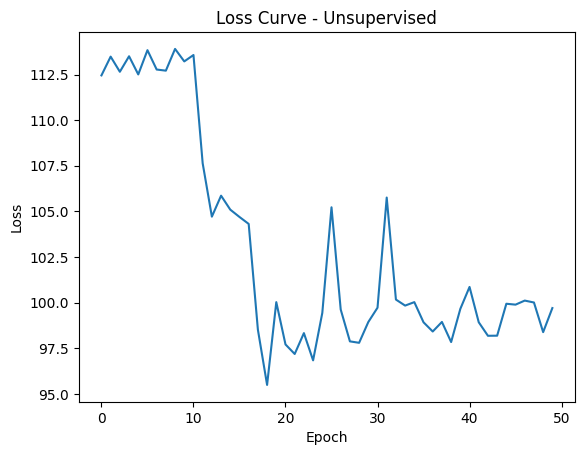

In [ ]:
import matplotlib.pyplot as plt

# Read loss values from the .txt file
with open("/content/drive/MyDrive/AutoPano/Phase2/unsup_50_64.txt", "r") as file:
    lines = file.readlines()

# Filter out blank spaces and lines, and convert to float
loss_values = [float(line.strip()) for line in lines if line.strip()]

# Plot the loss curve
plt.plot(loss_values)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve - Unsupervised")
plt.show()

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/AutoPano/Phase2/H4.csv')#, index_col = False)
data = data.to_numpy()